# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_openml('mnist_784', version=1, data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

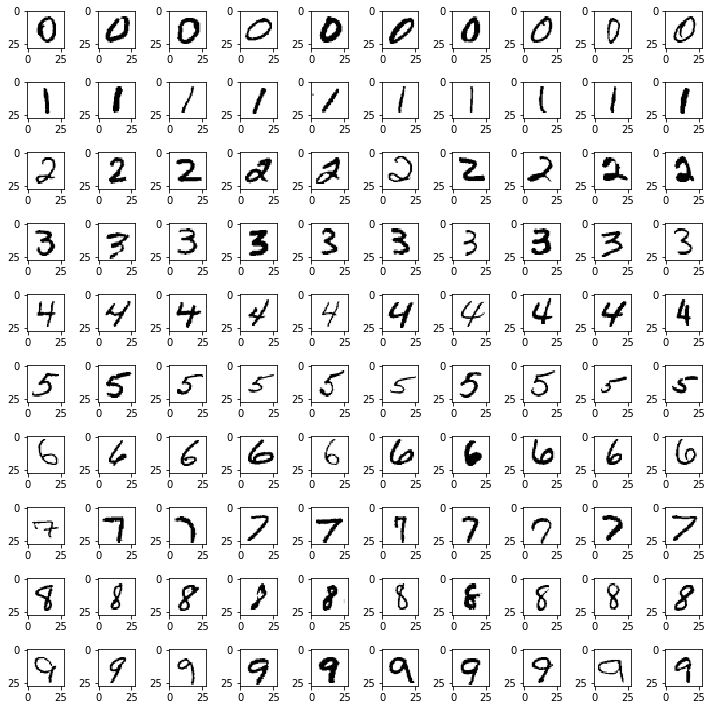

In [3]:
def P1(r,c):
    plt.figure(figsize=(10, 10))
    ii=0
    for i in range(r):
        train_data1 = mini_train_data[mini_train_labels==str(i)]
        for j in range(c):
            ii=ii+1
            img = train_data1[j].reshape((28,28))
            plt.tight_layout()
            plt.subplot(r,c,ii)
            plt.imshow(img, cmap="Greys")
    plt.show()
P1(10,10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):
    all_class = ['0','1','2','3','4','5','6','7','8','9']
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(mini_train_data,mini_train_labels)
        ##dev_data, dev_labels
        dev_labels_pred = knn.predict(dev_data)
        ##print(metrics.accuracy_score(mini_train_labels, mini_train_labels_pred))
        cm = confusion_matrix(dev_labels, dev_labels_pred)
        correct=0
        all_pred=0
        for i in range(len(cm)):
            ##print(cm[i][i]/sum(cm[i]))
            correct = correct+cm[i][i]
            all_pred = all_pred+sum(cm[i])
        print('Overall accuracy with K='+str(k)+' is '+str(correct*100/all_pred)+'%')
        print('And here is the classification report:\n'
              +str(classification_report(dev_labels, dev_labels_pred, target_names=all_class)))
        cr_dict = classification_report(dev_labels, dev_labels_pred, target_names=all_class,output_dict=True)
        for all_class_item in all_class:
            if all_class_item=='0':
                diff = all_class_item
            elif cr_dict[all_class_item]['f1-score'] < cr_dict[str(int(all_class_item)-1)]['f1-score']:
                diff = all_class_item
        print('The most difficult number to predict using k = '+str(k)+' is :'+str(diff)+'\n\n')

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Overall accuracy with K=1 is 88.4%
And here is the classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

The most difficult number to predict using k = 1 is :8


Overall accuracy with K=3 is 87.6%
And here is the classification report:
              precision    recall  f

ANSWER:

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_size):
    start_time = time.time()
    train_new = train_data[:train_size]
    train_new_labels = train_labels[:train_size]
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_new,train_new_labels)
    dev_labels_pred = knn.predict(dev_data)    
    cm = confusion_matrix(dev_labels, dev_labels_pred)
    correct=0
    all_pred=0
    for i in range(len(cm)):
        correct = correct+cm[i][i]
        all_pred = all_pred+sum(cm[i])
    print('Overall accuracy with N='+str(train_size)+' is '+str(correct*100/all_pred)+
          '% and time is '+str(time.time()-start_time)[:5]+' sec')
    return (correct*100/all_pred)
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
#train_sizes = [100, 200]
accuracies = []
for train_size in train_sizes:
    accuracies.append(P3(train_size))

Overall accuracy with N=100 is 70.2% and time is 0.128 sec
Overall accuracy with N=200 is 79.1% and time is 0.220 sec
Overall accuracy with N=400 is 81.1% and time is 0.467 sec
Overall accuracy with N=800 is 86.6% and time is 0.980 sec
Overall accuracy with N=1600 is 90.5% and time is 1.989 sec
Overall accuracy with N=3200 is 92.7% and time is 4.069 sec
Overall accuracy with N=6400 is 93.9% and time is 9.553 sec
Overall accuracy with N=12800 is 95.2% and time is 18.78 sec
Overall accuracy with N=25000 is 96.2% and time is 39.49 sec


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Linear log regression model predicted the accuracy of KNN for N=60,000 samples to be ~100%


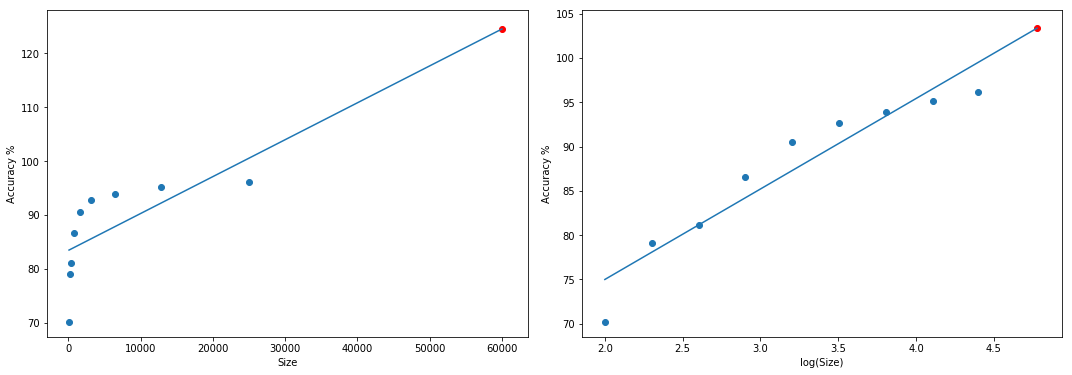

In [6]:
import math
def P4():
    # Method 1 - with raw n size
    logisticRegr = LinearRegression()
    sizeInput = np.reshape(train_sizes,(len(train_sizes),1))
    logisticRegr.fit(sizeInput, accuracies)
    
    # Method 2 - Log of n size
    sizeInput_log = np.reshape([math.log10(float(i)) for i in train_sizes],(len(train_sizes),1))
    logisticRegr_log = LinearRegression()
    logisticRegr_log.fit(sizeInput_log, accuracies)
    
    # scatter plot based on n size to accuracies from previous section
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.scatter(train_sizes, accuracies)
    # plot model based on raw n size
    sizeInput1 = sizeInput
    sizeInput1 = np.append(sizeInput1,[60000])
    sizeInput1 = np.reshape(sizeInput1,(len(sizeInput1),1))
    train_sizes1 = train_sizes
    train_sizes1.append(60000)
    plt.plot(sizeInput1, logisticRegr.predict(sizeInput1))
    plt.scatter(60000, logisticRegr.predict([[60000]]), color='red')
    
    plt.xlabel('Size')
    plt.ylabel('Accuracy %')
    
    
    # plot regression line and fitting data (with log10(training size) as input value)
    plt.subplot(2, 2, 2)
    plt.scatter(sizeInput_log, accuracies)
    plt.scatter(math.log10(float(60000)), logisticRegr_log.predict([[math.log10(float(60000))]]), color='red')
    sizeInput_log1 = np.reshape([math.log10(float(i)) for i in train_sizes1],(len(train_sizes1),1))
    plt.plot(sizeInput_log1, logisticRegr_log.predict(sizeInput_log1))
    plt.xlabel('log(Size)')
    plt.ylabel('Accuracy %')
    plt.tight_layout()
    print('Linear log regression model predicted the accuracy of KNN for N=60,000 samples to be ~100%')
    
P4()

From previous section, leanring time and accuracy of a KNN algorithm can be observed to non-linearly increasing with N-size. The first model with raw N-size does not show any similarity between the predicted and actual acuracy and N-size. While the Log of size and Accuracy fit the linear model more accurately

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

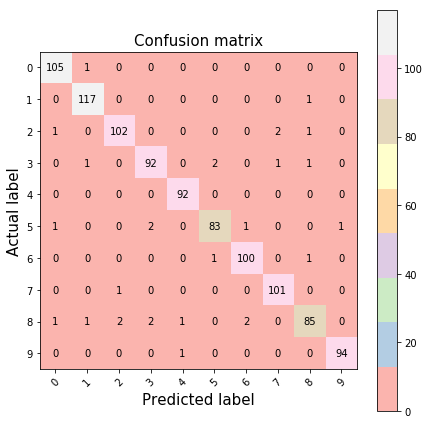

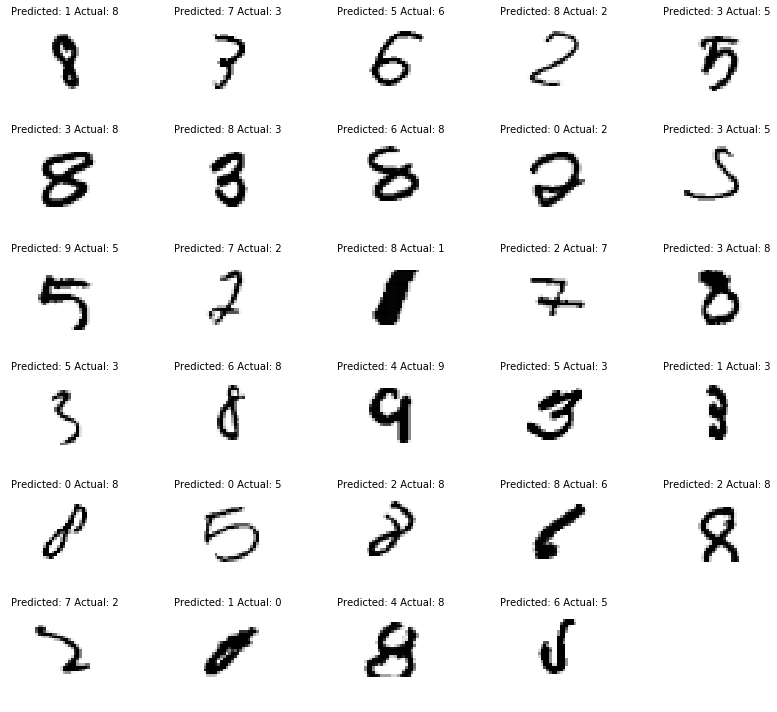

In [7]:
def P5():

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_data,train_labels)
    dev_labels_pred = knn.predict(dev_data)    
    cm = confusion_matrix(dev_labels, dev_labels_pred)
    #print(cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
    plt.title('Confusion matrix', size = 15)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
    plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
    plt.tight_layout()
    plt.ylabel('Actual label', size = 15)
    plt.xlabel('Predicted label', size = 15)
    width, height = cm.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',verticalalignment='center')
            
    plt.figure(figsize=(12,10))
    confused_pair_data = dev_data[dev_labels != dev_labels_pred]
    confused_pair_labels = dev_labels[dev_labels != dev_labels_pred]
    confused_pred_labels = dev_labels_pred[dev_labels != dev_labels_pred]
    c = len(confused_pair_data)
    for i in range(c):
        img = confused_pair_data[i].reshape((28,28))
        plt.subplot(1+int(c)/5,5,i+1)
        plt.imshow(img, cmap="Greys")
        plt.tight_layout()
        plt.title('Predicted: '+str(confused_pred_labels[i])+' Actual: '+str(confused_pair_labels[i]), fontsize = 10)
        plt.axis('off')
    plt.show()

P5()

By horizontally tracking the confusion matrix and the confused pairs above '4' has been predicted with 100% accuracy while 8 seems to be the most confused set to predict

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

(1000, 784)
Sample of Gaussian blurr


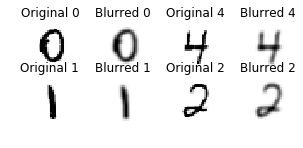

- preprocess the training data but not the dev data
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       106
           1       0.93      0.97      0.95       118
           2       0.93      0.86      0.89       106
           3       0.94      0.87      0.90        97
           4       0.93      0.84      0.88        92
           5       0.93      0.89      0.91        88
           6       0.92      0.95      0.93       102
           7       0.93      0.94      0.94       102
           8       0.82      0.85      0.84        94
           9       0.79      0.92      0.85        95

   micro avg       0.91      0.91      0.91      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.91      0.91      1000

5.613 sec
- preprocess the dev data but not the training data
Classification report:
              precision    recall  f1-score   support

           0       0.96   

In [8]:
from scipy.ndimage import gaussian_filter
def P6():
    var = 1.5
    neighbor_8 = [[i,j] for i in range(-1,2) for j in range(-1,2)]
    gaussianWeight = [math.exp(-(x**2+y**2)/(2*(var**2)))/(2*math.pi*(var**2)) for [x,y] in neighbor_8]
    NormalizingFact = sum(gaussianWeight)
    gaussianWeight = [ i / NormalizingFact for i in gaussianWeight]

    def GetNeighbour(r=2,c=1):
        ordinates = [[r+i,c+j] for i in range(-1,2) for j in range(-1,2)]
        return ordinates

    def ImageBlur(source):
        data_gauss = np.empty(len(mini_train_data)*784).reshape(len(mini_train_data),784)
        jj=0
        for mini_train_data_ITEM in source:
            data = mini_train_data_ITEM.reshape(28,28)
            for i in range(28):
                for j in range(28):
                    kk = 0
                    temp = 0
                    for ii in GetNeighbour(i,j):
                        if ii[0] in range(28) and ii[1] in range(28):
                            temp = temp + data[ii[0]][ii[1]]*gaussianWeight[kk]
                        kk = kk + 1
                    data_gauss[jj][(28*i)+j]=temp
            jj=jj+1
        return data_gauss

    train_data_gauss = ImageBlur(mini_train_data) 
    dev_data_gauss = ImageBlur(dev_data)
    print(train_data_gauss.shape)

    start_time=time.time()
    #train_data_gauss = [gaussian_filter(train_data, sigma=1) for i in range(len(train_labels))]
    #train_data_gauss = np.reshape(train_data_gauss[0],(len(mini_train_labels),784))
    #dev_data_gauss = [gaussian_filter(dev_data, sigma=1) for i in range(len(dev_data))]
    #dev_data_gauss = np.reshape(dev_data_gauss[0],(len(dev_data),784))

    print('Sample of Gaussian blurr')
    plt.figure(figsize=(5,10))
    j=0
    for i in range (4):
        data = mini_train_data[i]
        plt.subplot(10,4,j+1)
        plt.imshow(data.reshape((28,28)),cmap='Greys')
        plt.title('Original '+str(mini_train_labels[i]))
        plt.axis('off')
        
        data = train_data_gauss[i]
        plt.subplot(10,4,j+2)
        plt.imshow(data.reshape((28,28)),cmap='Greys')
        plt.title('Blurred '+str(mini_train_labels[i]))
        plt.axis('off')
        
        j=j+2
        
    plt.show()
    all_class = ['0','1','2','3','4','5','6','7','8','9']
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_data_gauss,mini_train_labels)
    dev_labels_pred = knn.predict(dev_data)
    print('- preprocess the training data but not the dev data')
    print('Classification report:\n'
              +str(classification_report(dev_labels, dev_labels_pred, target_names=all_class))+
          '\n'+str(time.time()-start_time)[:5]+' sec')

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(mini_train_data,mini_train_labels)
    dev_labels_pred = knn.predict(dev_data_gauss)
    print('- preprocess the dev data but not the training data')
    print('Classification report:\n'
              +str(classification_report(dev_labels, dev_labels_pred, target_names=all_class))+
         '\n'+str(time.time()-start_time)[:5]+' sec')
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_data_gauss,mini_train_labels)
    dev_labels_pred = knn.predict(dev_data_gauss)
    print('- preprocess both training and dev data')
    print('Classification report:\n'
              +str(classification_report(dev_labels, dev_labels_pred, target_names=all_class))+
         '\n'+str(time.time()-start_time)[:5]+' sec')
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(mini_train_data,mini_train_labels)
    dev_labels_pred = knn.predict(dev_data)
    print('- No blurring of either data')
    print('Classification report:\n'
              +str(classification_report(dev_labels, dev_labels_pred, target_names=all_class))+
         '\n'+str(time.time()-start_time)[:5]+' sec')
    

P6()

- In above code, 1-NN has been applied 4 ways by considering seperate combinations of Blurred and original Training and Dev data.
- It can be notted that with blurring, the non-diagonal metrics in the confusion matrix has reduced in the three attempts with Blurring of either or both Training and Dev data

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

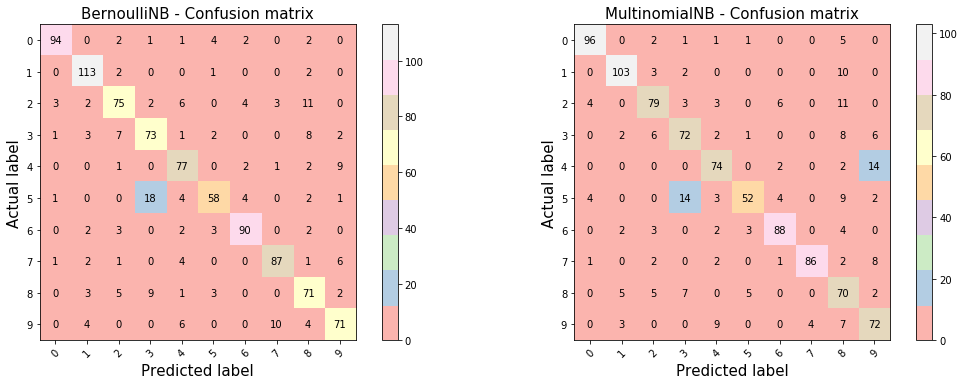

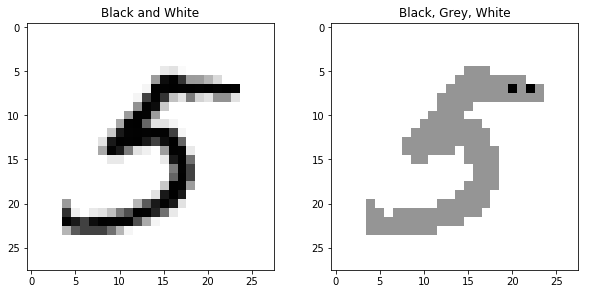

In [9]:
def P7():

    def print_CM(cm, title):
        plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
        plt.title(title, size = 15)
        plt.colorbar()
        tick_marks = np.arange(10)
        plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
        plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
        plt.tight_layout()
        plt.ylabel('Actual label', size = 15)
        plt.xlabel('Predicted label', size = 15)
        width, height = cm.shape
        for x in range(width):
            for y in range(height):
                plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',verticalalignment='center')

    #METHOD 1 - BernoulliNB
    Binary_NB = BernoulliNB(alpha = 1, binarize = 0, fit_prior = True)
    Binary_NB.fit(mini_train_data, mini_train_labels)
    dev_data_pred = Binary_NB.predict(dev_data)
    #print(classification_report(dev_labels, dev_data_pred))
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    print_CM(confusion_matrix(dev_labels, dev_data_pred),'BernoulliNB - Confusion matrix')

    #METHOD 1 - MultinomialNB

    mini_train_012 = mini_train_data.copy()
    mini_train_012[mini_train_012==1] = 2 #1 IS WHITE(2), 0 IS BLACK(0), EVERYTHING ELSE GREY(1) 
    mini_train_012[np.array(mini_train_012!=2) & np.array(mini_train_012!=0)] = 1

    dev_012 = dev_data.copy()
    dev_012[dev_012==1] = 2
    dev_012[np.array(dev_012!=2) & np.array(dev_012!=0)] = 1

    Poly_NB = MultinomialNB()
    Poly_NB.fit(mini_train_012, mini_train_labels)
    Poly_NB_dev_pred = Poly_NB.predict(dev_012)
    plt.subplot(2,2,2)
    print_CM(confusion_matrix(dev_labels, Poly_NB_dev_pred),'MultinomialNB - Confusion matrix')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.title('Black and White')
    plt.imshow(mini_train_data[mini_train_labels=='5'][0].reshape(28,28),cmap='Greys')
    plt.subplot(2,2,2)
    plt.title('Black, Grey, White')
    plt.imshow(mini_train_012[mini_train_labels=='5'][0].reshape(28,28),cmap='Greys')
    plt.show()
P7()

- From the above comparison of confusion metrix from both Bernoulli and Multinomial Naive Base approach, it is apparent that Bernoulli has a better prediction accuracy
- From the sample plots above, it can be concluded that by converting into BGW the feature space has reduced since most pixle values are in grey

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [10]:
#def P8(alphas):

def P8(alphas):
    Binary_NB = BernoulliNB(binarize=0.0)
    Search_Alpha = GridSearchCV(Binary_NB, alphas)
    Search_Alpha.fit(mini_train_data, mini_train_labels)
    Best_Alpha = Search_Alpha.best_estimator_
    # evaluate accuracy for best estimator
    print('Best Estimater:\n'+str(Best_Alpha))
    dev_data_pred = Best_Alpha.predict(dev_data)  # using the best parameter
    print('Accuracy of the best estimator:' +str(Best_Alpha.score(dev_data, dev_labels)))
    #print(classification_report(dev_data_pred, dev_labels))
    

    # evaluate accuracy for alpha=0    
    print('\nEvaluate Bernoulli NB when alpha=0')
    Binary_NB = BernoulliNB(alpha=0, binarize=0.0)    
    Binary_NB.fit(mini_train_data, mini_train_labels)
    dev_data_pred = Binary_NB.predict(dev_data)
    print('Accuracy without smoothing:'+str(Binary_NB.score(dev_data, dev_labels)))
    #print(classification_report(pred0, dev_labels))
    return Search_Alpha


alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

C:\Users\kfpj179\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kfpj179\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\kfpj179\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\kfpj179\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best Estimater:
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
Accuracy of the best estimator:0.824

Evaluate Bernoulli NB when alpha=0
Accuracy without smoothing:0.816


C:\Users\kfpj179\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\kfpj179\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [11]:
print(nb.best_params_)

{'alpha': 0.01}


- The best Bernoulli NB has a smoothing factor of 0.01
- Bernoulli NB with smoothing factor alpha=0.01 is performing better than without smoothing. There are 784 dimensions in the feature space with conditional probability 0 for many pixles skewing the prediction.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [12]:
def P9():
    
    GaussNB = GaussianNB()
    GaussNB.fit(mini_train_data, mini_train_labels)
    
    print('Maximum variation of each digit:')
    print(np.max(GaussNB.sigma_,1))
    
    print('\nClassification report of original model:')
    print(classification_report(GaussNB.predict(dev_data), dev_labels))
       
    GaussNB.sigma_ = GaussNB.sigma_ * 0.01
    
    print('\nClassification report after sigma modification:')
    print(classification_report(GaussNB.predict(dev_data), dev_labels))


P9()

Maximum variation of each digit:
[0.21201231 0.21206427 0.20966724 0.20051704 0.20135957 0.20426691
 0.20144224 0.20718447 0.19721129 0.20207091]

Classification report of original model:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       124
           1       0.81      0.87      0.84       110
           2       0.44      0.59      0.51        79
           3       0.29      0.64      0.40        44
           4       0.32      0.78      0.45        37
           5       0.67      0.30      0.41       199
           6       0.85      0.74      0.79       118
           7       0.57      0.92      0.70        63
           8       0.11      0.38      0.17        26
           9       0.91      0.43      0.58       200

   micro avg       0.59      0.59      0.59      1000
   macro avg       0.58      0.64      0.57      1000
weighted avg       0.71      0.59      0.61      1000


Classification report after sigma modification:
    

- The varience associated with each number is considerable, mainly due to the different representation of each number
- With large enough variations the noisy representations of a number can skew the conditional probability, resulting into incorrect predictions
- To reduce this effect, we can optimize the sigma estimate. Results with sigma = 0.01 show f1-score, precision and accuracy (recall) are significantly improved and is only a few % less than Naive Bayes Estimator

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

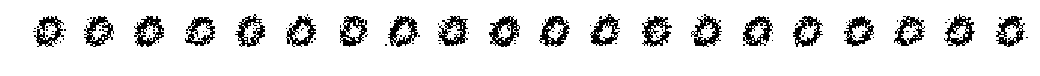

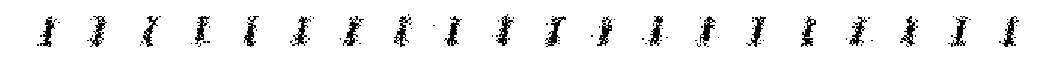

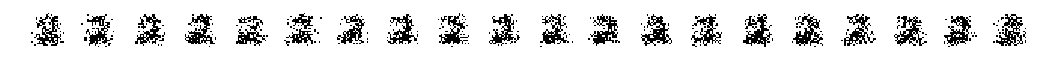

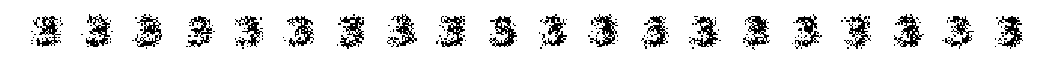

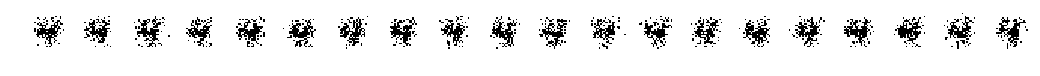

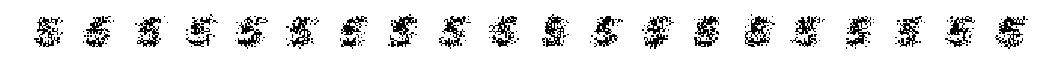

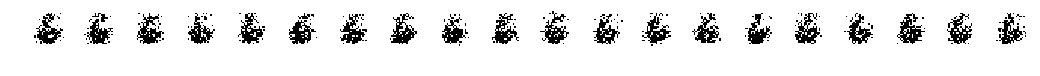

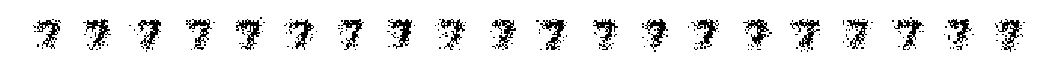

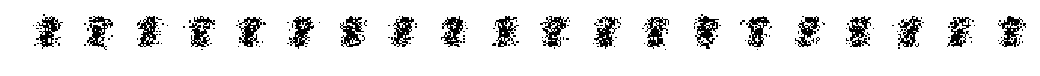

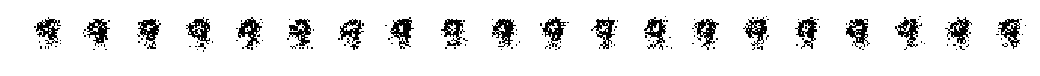

In [13]:
def P10(sample_size):
    Binary_NB = BernoulliNB(binarize = 0.0, alpha = 0.001)
    # training
    Binary_NB.fit(mini_train_data, mini_train_labels)
    # get likelihood
    features_prob = np.exp(Binary_NB.feature_log_prob_)
    
    i = 1    
    for num in range(10):
        digits = np.transpose(np.array([np.random.rand(sample_size)<x for x in features_prob[num]]))
        # plot each digit
        plt.figure(figsize=(18, 9))
        for digit in digits:
            plt.subplot(10, sample_size, i)
            plt.imshow(np.reshape(digit,(28,28)), cmap = "Greys")
            plt.axis('off')
            i += 1

P10(20)

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

p(predicted) <= 0.5 total = 0 accuracy = 0.0%
p(predicted) <= 0.9 total = 30 accuracy = 33.33%
p(predicted) <= 0.999 total = 72 accuracy = 43.06%
p(predicted) <= 0.99999 total = 59 accuracy = 50.85%
p(predicted) <= 0.9999999 total = 51 accuracy = 66.67%
p(predicted) <= 0.999999999 total = 53 accuracy = 79.25%
p(predicted) <= 0.99999999999 total = 35 accuracy = 74.29%
p(predicted) <= 0.9999999999999 total = 46 accuracy = 76.09%
p(predicted) <= 1.0 total = 654 accuracy = 94.19%


Text(0.5, 1.0, 'Bernoulli NP Calibration')

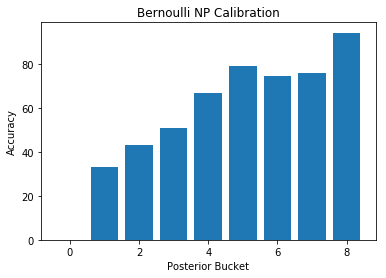

In [14]:
from bisect import bisect_left

def P11(buckets, correct, total):
    Binary_NB = BernoulliNB(alpha = 0.01, binarize = 0)
    Binary_NB.fit(mini_train_data, mini_train_labels)
    
    posteriors = Binary_NB.predict_proba(dev_data)
    confidence = np.amax(posteriors, axis=1)
    Correct = np.argmax(posteriors, axis=1) == dev_labels.astype(int)
    INCorrect = np.argmax(posteriors, axis=1) != dev_labels.astype(int)
    
    bucket = np.empty(2*len(confidence)).reshape(len(confidence),2)
    i=0
    for confidence_ITEM in confidence:
        for buckets_ITEM in buckets:
            if confidence_ITEM <= buckets_ITEM:
                c=0
                if(Correct[i]):
                    c=1
                bucket[i] = [buckets_ITEM,c]
                break
        i=i+1
    
    j=1
    #print(bucket)
    chartdata = np.empty(3*len(buckets)).reshape(9,3)
    for i in buckets:
        Total = len(list(filter(lambda x: x[0] == i, bucket)))
        if Total > 0:
            accuracy = len(list(filter(lambda x: x[0] == i and x[1]==1, bucket)))*100/Total
        else:
            accuracy = 0
        chartdata[j-1] = [j,Total,accuracy]
        j=j+1
    
    for i in range(len(buckets)):
        print('p(predicted) <= '+ str(buckets[i])+' total = '+str(int(chartdata[i][1]))+' accuracy = '
              +str(round(chartdata[i][2],2))+'%')
    return chartdata
    
    
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]
chartdata = P11(buckets, correct, total)
                
plt.bar(range(9), [chartdata[i][2] for i in range(9)])
plt.xlabel('Posterior Bucket')
plt.ylabel('Accuracy')
plt.title('Bernoulli NP Calibration')
   

Accuracy increases when the posteriors grows

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [16]:
def addFeatures(digit):
    # sum row and column to add 28x2=56 features
    rtn = digit.copy()
    sqr = np.reshape(digit, (28,28))
    return np.concatenate([rtn, np.sum(sqr, axis = 0), np.sum(sqr, axis = 1)])
    

def P12():
    # add feature for training and dev data
    newTrain = [addFeatures(x) for x in mini_train_data]
    newDev = [addFeatures(x) for x in dev_data]
    # build Bernoulli NP model
    nb = BernoulliNB(binarize=0.5, alpha=0.01)
    nb.fit(newTrain, mini_train_labels)
    
    nb2 = BernoulliNB(binarize = 0.5, alpha = 0.01)
    nb2.fit(mini_train_data, mini_train_labels)
    print('Accuracy with added features:'+str(nb.score(newDev, dev_labels)))
    print('Accuracy without added features:'+str(nb2.score(dev_data, dev_labels)))
    

### STUDENT END ###

P12()

Accuracy with added features:0.827
Accuracy without added features:0.829


There isn't a huge difference with the additional features